In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

RANDOM_STATE = 14

# Create Dataset

In [41]:
X, y = make_blobs(
    n_samples=1000, n_features=2, cluster_std=3, centers=3, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True, stratify=y
)

# standardize dataset
scaler= StandardScaler()
scaler.fit(X_train)
X_train= scaler.transform(X_train)
X_val= scaler.transform(X_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((800, 2), (800,), (200, 2), (200,))

[]

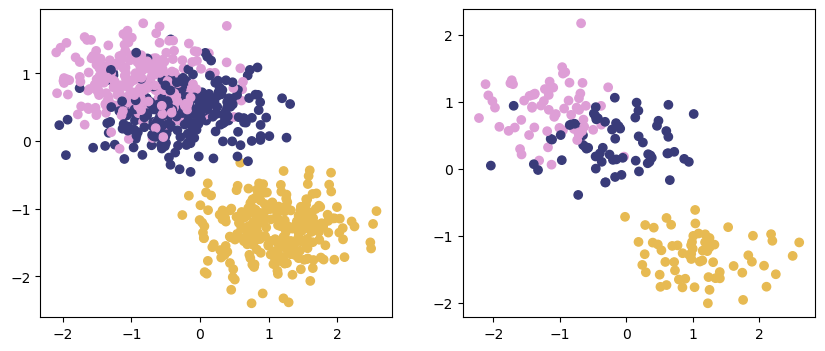

In [42]:
fig = plt.figure(figsize=(10, 4))

fig.add_subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="tab20b")
plt.plot()

fig.add_subplot(1, 2, 2)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap="tab20b")
plt.plot()

# Build Model

In [43]:
class Model(nn.Module):
    def __init__(self, n_input, n_neuron, n_output):
        super().__init__()
        l1 = nn.Linear(n_input, n_neuron)
        ac1 = nn.ReLU()
        l2 = nn.Linear(n_neuron, n_neuron)
        ac2 = nn.ReLU()
        l3 = nn.Linear(n_neuron, n_neuron)
        ac3 = nn.ReLU()
        l4 = nn.Linear(n_neuron, n_output)
        ac4 = nn.Softmax(dim= 1)
        self.module_list = nn.ModuleList([l1, ac1, l2, ac2, l3, ac3, l4, ac4])

    def forward(self, X):
        for f in self.module_list:
            X = f(X)
        return X

    def predict(self, X):
        X= torch.from_numpy(X).float()
        y_pred_proba = self.forward(X)
        return torch.argmax(y_pred_proba, axis= 1).int()

# Train

In [44]:
torch.manual_seed(RANDOM_STATE)

lr = 0.001
batch_size = 10
n_input = X_train.shape[1]  # num features
n_neuron = 8  # num neurons in hidden layer
n_output = len(np.unique(y_train))  # n classes

model = Model(n_input, n_neuron, n_output)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

# cast train to float 32
# create dataloader
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train)
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

X_val_tensor= torch.from_numpy(X_val).float()
y_val_tensor= torch.from_numpy(y_val)

def train_val(model, loss_fn, optimizer, train_dl, X_val, y_val, n_epochs):
    loss_hist_train = [0] * n_epochs
    loss_hist_val = [0] * n_epochs
    acc_hist_train = [0] * n_epochs
    acc_hist_val = [0] * n_epochs
    n_train_samples = len(train_dl.dataset)
    batch_size = train_dl.batch_size

    for epoch in range(n_epochs):
        # train
        for X_batch, y_batch in train_dl:
            y_pred_proba = model(X_batch)

            # calculate and backpropagate loss
            loss = loss_fn(y_pred_proba, y_batch)
            loss.backward()

            # update params and reset grad
            optimizer.step()
            optimizer.zero_grad()

            # get acc
            y_pred = torch.argmax(y_pred_proba, axis=1).float()
            correct_pred = (y_pred == y_batch).float().sum()

            # update history
            loss_hist_train[epoch] += loss.item() * batch_size
            acc_hist_train[epoch] += correct_pred.item()

        acc_hist_train[epoch] /= n_train_samples
        loss_hist_train[epoch] /= n_train_samples

    return acc_hist_train, loss_hist_train

In [45]:
n_epochs = 50
output = train_val(model, loss_fn, optimizer, train_dl, X_val, y_val, n_epochs)

acc_hist_train, loss_hist_train = output

/tmp/ipykernel_16001/2908532064.py:17: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y= y_val_tensor.numpy().astype(np.integer),


Text(0.5, 0, '$x_1$')

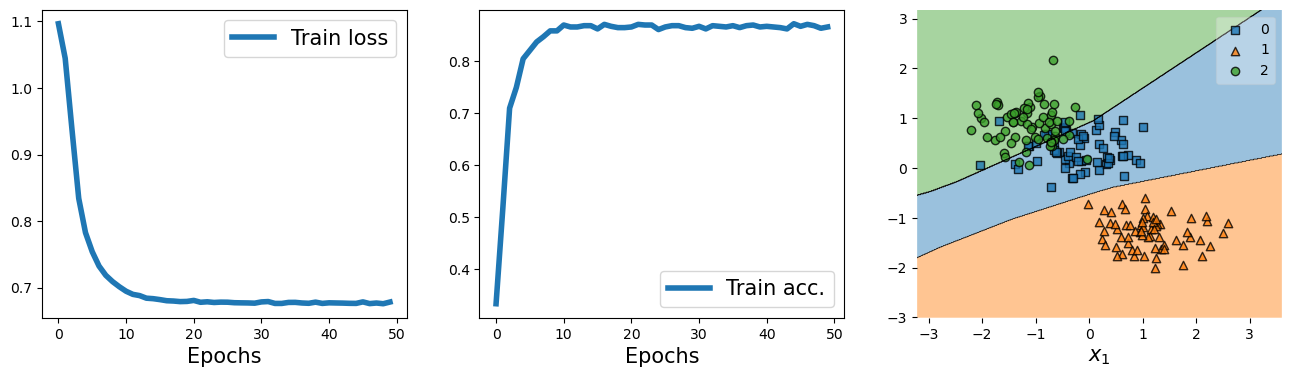

In [46]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
# plt.plot(loss_hist_val, lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(acc_hist_train, lw=4)
# plt.plot(acc_hist_val, lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X= X_val_tensor.numpy(),
                      y= y_val_tensor.numpy().astype(np.integer),
                      clf= model)
ax.set_xlabel(r'$x_1$', size=15)

# Val

In [47]:
X_val_tensor= torch.from_numpy(X_val).float()
y_val_tensor= torch.from_numpy(y_val)

y_pred_proba= model(X_val_tensor)
y_pred= torch.argmax(y_pred_proba, axis= 1)
acc= (y_pred == y_val_tensor).float().mean().item()

print(f'Val acc: {acc: .5f}')

Val acc:  0.86500


# Train with Val

In [48]:
torch.manual_seed(RANDOM_STATE)

lr = 0.001
batch_size = 10
n_input = X_train.shape[1]  # num features
n_neuron = 8  # num neurons in hidden layer
n_output = len(np.unique(y_train))  # n classes

model = Model(n_input, n_neuron, n_output)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

# cast train to float 32
# create dataloader
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train)
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

X_val_tensor= torch.from_numpy(X_val).float()
y_val_tensor= torch.from_numpy(y_val)

def train_val(model, loss_fn, optimizer, train_dl, X_val, y_val, n_epochs):
    loss_hist_train = [0] * n_epochs
    loss_hist_val = [0] * n_epochs
    acc_hist_train = [0] * n_epochs
    acc_hist_val = [0] * n_epochs
    n_train_samples = len(train_dl.dataset)
    batch_size = train_dl.batch_size

    for epoch in range(n_epochs):
        # train
        for X_batch, y_batch in train_dl:
            y_pred_proba = model(X_batch)

            # calculate and backpropagate loss
            loss = loss_fn(y_pred_proba, y_batch)
            loss.backward()

            # update params and reset grad
            optimizer.step()
            optimizer.zero_grad()

            # get acc
            y_pred = torch.argmax(y_pred_proba, axis=1).float()
            correct_pred = (y_pred == y_batch).float().sum()

            # update history
            loss_hist_train[epoch] += loss.item() * batch_size
            acc_hist_train[epoch] += correct_pred.item()

        acc_hist_train[epoch] /= n_train_samples
        loss_hist_train[epoch] /= n_train_samples

        # val
        y_pred_proba= model(X_val)
        y_pred= torch.argmax(y_pred_proba, dim= 1)
        acc= (y_pred == y_val).float().mean()
        loss= loss_fn(y_pred_proba, y_val)
        acc_hist_val[epoch] = acc.detach().item()
        loss_hist_val[epoch] = loss.detach().item()

    return acc_hist_train, loss_hist_train, acc_hist_val, loss_hist_val

In [49]:
n_epochs = 50
output = train_val(model,
                   loss_fn,
                   optimizer,
                   train_dl,
                   X_val_tensor,
                   y_val_tensor,
                   n_epochs)
acc_hist_train, loss_hist_train, acc_hist_val, loss_hist_val = output

/tmp/ipykernel_16001/2076496186.py:17: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y= y_val_tensor.numpy().astype(np.integer),


Text(0.5, 0, '$x_1$')

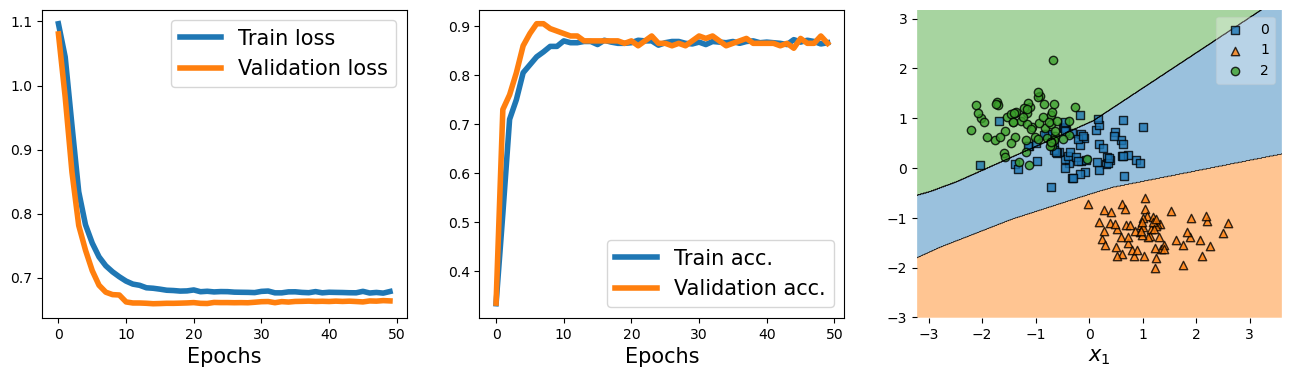

In [50]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_val, lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(acc_hist_train, lw=4)
plt.plot(acc_hist_val, lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X= X_val_tensor.numpy(),
                      y= y_val_tensor.numpy().astype(np.integer),
                      clf= model)
ax.set_xlabel(r'$x_1$', size=15)